In the last part, we tried to classify our images of dogs according to their breeds by building a neural network from scratch: the model was too simple for the task.

In this part, we are going to classify our images by using transfer learning from a pretrained network. Transfer learning is a technique that consists of using a neural network that was already trained on similar task that we want to tackle.

Here, we are going to focus on training and fine tuning the model not on the preprocessing step.

**References:**

* [Transfer learning and fine-tuning](https://www.tensorflow.org/guide/keras/transfer_learning#setup) guide from tensorflow.
* [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning#data_preprocessing) tutorial from tensorflow.
* [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers#preprocessing_data_before_the_model_or_inside_the_model) tutorial from tensorflow.
* Chapter14: Deep computer vision using convolutional neural networks from the book hands on machine learning.
* [This](https://github.com/Djinny/Formation-Data-Scientist/blob/master/Reconnaissance%20d'image%20sur%20120%20classes/%C3%89tat%20de%20l'Art%20-%20Deep%20Learning.ipynb) notebook.

# Import libraries

In [84]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model

DOWNLOAD_ROOT = "http://vision.stanford.edu/aditya86/ImageNetDogs/"
FILENAME = "images.tar"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
data_dir = Path(filepath).parent / "Images"
data_dir

PosixPath('/root/.keras/datasets/Images')

In [85]:
class_names = os.listdir(data_dir)
n_classes = len(os.listdir(data_dir))

n_images = 0
for i in range(n_classes):
    n_images += len(os.listdir(data_dir / class_names[i]))
print("Number of images: ", n_images)
print("Number of classes: ", n_classes)

Number of images:  20580
Number of classes:  120


# Load using tf.data

In [86]:
def filepaths(data_dir, test_ratio=0.2, validation_ratio=0.2):
    test_ratio = test_ratio
    validation_ration = validation_ratio

    train_filepaths = []
    valid_filepaths = []
    test_filepaths = []

    path = os.path.join("/root/.keras/datasets/", "Images/" )
    for i in range(n_classes):
        img_per_cat = os.listdir(data_dir / class_names[i])
        img_per_cat = np.array([os.path.join(class_names[i], s) for s in img_per_cat])
        
        total_size = len(img_per_cat) # ex. 157
        test_size = int(total_size * test_ratio) # ex. 31
        validation_size = int(total_size * validation_ratio) # ex. 31
        train_size = total_size - test_size - validation_size # ex. 95

        rnd_indices = np.random.permutation(total_size)

        train_filepaths.append(img_per_cat[rnd_indices[:train_size]])
        valid_filepaths.append(img_per_cat[rnd_indices[train_size:-test_size]])
        test_filepaths.append(img_per_cat[rnd_indices[-test_size:]])

    train_filepaths = np.array([path + s for s in np.hstack(train_filepaths)])
    valid_filepaths = np.array([path + s for s in np.hstack(valid_filepaths)])
    test_filepaths = np.array([path + s for s in np.hstack(test_filepaths)])

    return (train_filepaths, valid_filepaths, test_filepaths)

(train_filepaths, valid_filepaths, test_filepaths) = filepaths(data_dir)
train_filepaths.shape, valid_filepaths.shape, test_filepaths.shape

((12436,), (4072,), (4072,))

In [87]:
# In the last part I said that we will put a Normalization layer within the model
# to simplify deployment but this slow down training too much so this is why I put 
# the Rescaling layer in tf.data

norm_layer = layers.experimental.preprocessing.Rescaling(1./255)

def get_label(file_path):
    """Takes the label from the file path"""
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    one_hot = tf.cast(one_hot, tf.float32)
    return tf.argmax(one_hot)

def preprocess_xception(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    final_img = keras.applications.xception.preprocess_input(img)
    return img, label

def preprocess_mobilenet(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    final_img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img, label

def create_dataset(filepaths, preprocess, batch_size=32, buffer_size=1000):
    ds = tf.data.Dataset.list_files(filepaths, seed=42)
    ds = ds.map(preprocess, num_parallel_calls=5)
    ds = ds.map(lambda x, y: (norm_layer(x), y), num_parallel_calls=5)
    ds = ds.shuffle(buffer_size, seed=42)
    ds = ds.batch(batch_size)
    return ds.prefetch(1)

# Model 1: Xception

In [88]:
train_set_xception = create_dataset(train_filepaths, preprocess_xception) 
valid_set_xception = create_dataset(valid_filepaths, preprocess_xception)
test_set_xception = create_dataset(test_filepaths, preprocess_xception)

Let's first use the pretrained Xception model that was trained on the ImageNet dataset.

The steps that we are going to follow to implement transfer learning are:

* We load the pretrained model excluding the top layers
* Freeze the weights of the pretrained layers
* Add a new model on top of the frozen layers
* Train the new model on our dataset

In [89]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

base_model_xception = tf.keras.applications.Xception(weights="imagenet", include_top=False)

# Create a new model on top
avg = layers.GlobalAveragePooling2D()(base_model_xception.output)
dense = layers.Dense(128, activation='relu')(avg)
output = layers.Dense(n_classes, activation="softmax")(dense)
xception_model = Model(inputs=base_model_xception.input, outputs=output)

# Freeze the weights of the base model
for layer in base_model_xception.layers:
    layer.trainable = False

# Compile the model and start training
xception_model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [90]:
import os 

root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)
epochs = 40

In [91]:
history_xception = xception_model.fit(train_set_xception, epochs=epochs, 
                                      validation_data=valid_set_xception, 
                                      callbacks=[early_stopping_cb, tensorboard_cb])
# Let's save the model before we do fine-tuning
xception_model.save("xception_without_fine_tuning.h5")

Epoch 1/40
389/389 [==============================] - 49s 116ms/step - loss: 4.0762 - accuracy: 0.2243 - val_loss: 1.7239 - val_accuracy: 0.7237
Epoch 2/40
389/389 [==============================] - 45s 112ms/step - loss: 1.3879 - accuracy: 0.7616 - val_loss: 0.9582 - val_accuracy: 0.7795
Epoch 3/40
389/389 [==============================] - 45s 113ms/step - loss: 0.8359 - accuracy: 0.8069 - val_loss: 0.7991 - val_accuracy: 0.7908
Epoch 4/40
389/389 [==============================] - 46s 114ms/step - loss: 0.7134 - accuracy: 0.8129 - val_loss: 0.7440 - val_accuracy: 0.8001
Epoch 5/40
389/389 [==============================] - 45s 112ms/step - loss: 0.6175 - accuracy: 0.8307 - val_loss: 0.7155 - val_accuracy: 0.7981
Epoch 6/40
389/389 [==============================] - 45s 112ms/step - loss: 0.5624 - accuracy: 0.8419 - val_loss: 0.6897 - val_accuracy: 0.8094
Epoch 7/40
389/389 [==============================] - 45s 112ms/step - loss: 0.5183 - accuracy: 0.8543 - val_loss: 0.6824 - val_ac

# Learning curves

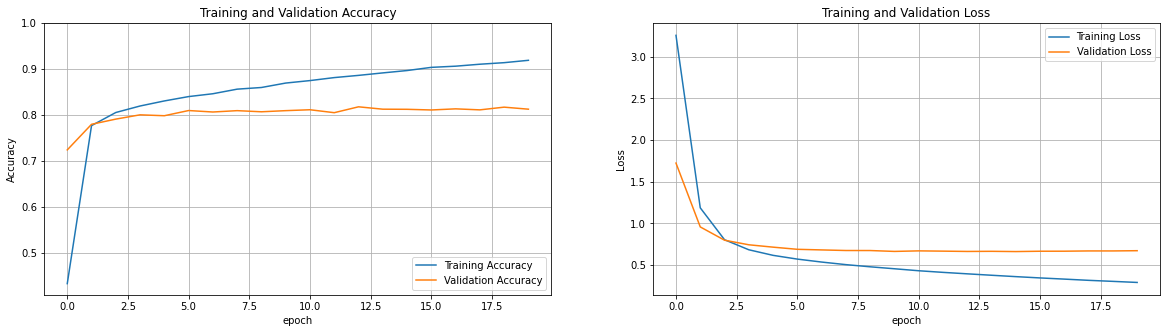

In [92]:
def plot_learning_curves(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.grid(True)
    plt.show()
    
plot_learning_curves(history_xception)

We can see that there is a noticeable difference in accuracy between training and validation accuracy: the model is overfitting. Before we try to regularize the model let's try another model and see if it performs better than this one.

# Model 1: MobilNetv2

Create the datasets:

In [93]:
train_set_mobilenet = create_dataset(train_filepaths, preprocess_mobilenet) 
valid_set_mobilenet = create_dataset(valid_filepaths, preprocess_mobilenet)
test_set_mobilenet = create_dataset(test_filepaths, preprocess_mobilenet)

Create the model:

In [94]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

base_model_mobilenet = tf.keras.applications.MobileNetV2(
                                    weights="imagenet", include_top=False)

# Create a new model on top
avg = layers.GlobalAveragePooling2D()(base_model_mobilenet.output)
dense1 = layers.Dense(128, activation='relu')(avg)
dense2 = layers.Dense(64, activation='relu')(dense1)
output = layers.Dense(n_classes, activation="softmax")(dense2)
mobilenet_model = Model(inputs=base_model_mobilenet.input, outputs=output)

# Freeze the weights of the base model
for layer in base_model_mobilenet.layers:
    layer.trainable = False

# Compile the model and start training
mobilenet_model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
mobilenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, None, None, 3 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [95]:
history_mobilenet = mobilenet_model.fit(train_set_mobilenet, epochs=epochs, 
                                        validation_data=valid_set_mobilenet, 
                                        callbacks=[early_stopping_cb, tensorboard_cb])

Epoch 1/40
389/389 [==============================] - 31s 72ms/step - loss: 4.6008 - accuracy: 0.0514 - val_loss: 3.4109 - val_accuracy: 0.2910
Epoch 2/40
389/389 [==============================] - 28s 69ms/step - loss: 2.8676 - accuracy: 0.4087 - val_loss: 1.8194 - val_accuracy: 0.5798
Epoch 3/40
389/389 [==============================] - 29s 70ms/step - loss: 1.5545 - accuracy: 0.6324 - val_loss: 1.3490 - val_accuracy: 0.6456
Epoch 4/40
389/389 [==============================] - 28s 69ms/step - loss: 1.1552 - accuracy: 0.7041 - val_loss: 1.1670 - val_accuracy: 0.6852
Epoch 5/40
389/389 [==============================] - 29s 71ms/step - loss: 0.9740 - accuracy: 0.7391 - val_loss: 1.0733 - val_accuracy: 0.7021
Epoch 6/40
389/389 [==============================] - 28s 69ms/step - loss: 0.8671 - accuracy: 0.7576 - val_loss: 1.0043 - val_accuracy: 0.7129
Epoch 7/40
389/389 [==============================] - 28s 68ms/step - loss: 0.7608 - accuracy: 0.7873 - val_loss: 0.9639 - val_accuracy:

# Learning curves

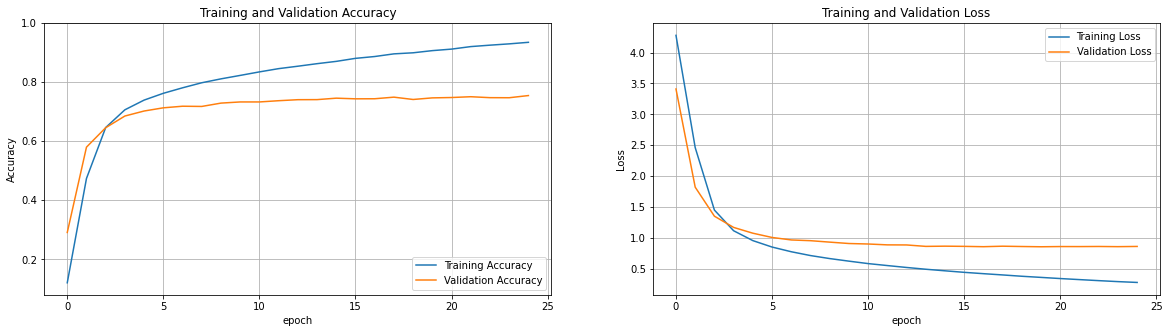

In [96]:
plot_learning_curves(history_mobilenet)

Let's build a table to compare the 2 models:

 <table style="width:50%; border: 1px solid black; border-collapse: collapse;">
  <tr>
    <th>Model</th>
    <th>accuracy</th>
    <th>val_accuracy</th>
    <th>time per epoch</th>
  </tr>
  <tr>
    <td>Xception</td>
    <td>92%</td>
    <td>81%</td>
    <td>45s</td>
  </tr>
  <tr>
    <td>MobileNetv2</td>
    <td>93%</td>
    <td>75%</td>
    <td>28s</td>
  </tr>
</table> 

Both models are overfitting the dataset but the MobileNet model is much more overfitting than the Xception model, on the other hand, MobileNet is much faster than Xception. Since I don't have too much computing power I will use the MobileNet model to try fine-tuning and regularization.

To fight overfitting, we will use data augmentation and dropout. Dropout is a technique that consist of randomly ignore units at every training step. Data augmentation generate additional training data from existing ones by applying random transformations. Data augmentation can be applied in two ways:
* Using Keras preprocessing layers
    
     There are two options to use the preprocessing layers:
     * 1 Make the preprocessing layers part of the model
     * 2 Apply the preprocessing layers directly to the dataset
* Using tf.image

Here we are going to make the preprocessing layers part of the model. Note that data augmentation and dropout layers are inactive at inference time.

# Data augmentation and Dropout

In [97]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
])

Let's visualize an image after applying the above random transformations:

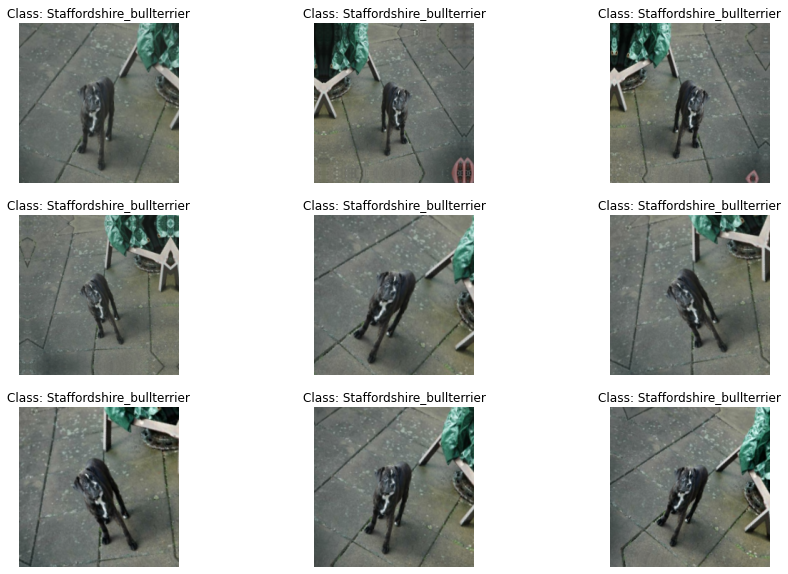

In [98]:
plt.figure(figsize=(15, 10))
for images, labels in train_set_mobilenet.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0])
        plt.title("Class: " + class_names[labels[0]][10:])
        plt.axis("off")

In [99]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

base_model_mobilenet = tf.keras.applications.MobileNetV2(
                                    weights="imagenet", include_top=False)

# Create a new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model_mobilenet(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)
mobilenet_model = Model(inputs=inputs, outputs=outputs)

# Freeze the weights of the base model
for layer in base_model_mobilenet.layers:
    layer.trainable = False

# Compile the model and start training
mobilenet_model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
mobilenet_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560 

In [100]:
history_mobilenet = mobilenet_model.fit(train_set_mobilenet, epochs=epochs, 
                                        validation_data=valid_set_mobilenet, 
                                        callbacks=[early_stopping_cb, tensorboard_cb])
# Let's save the model before we do fine-tuning
mobilenet_model.save("mobilenet_without_fine_tuning.h5")

Epoch 1/40
389/389 [==============================] - 33s 75ms/step - loss: 4.3646 - accuracy: 0.1024 - val_loss: 2.0041 - val_accuracy: 0.5926
Epoch 2/40
389/389 [==============================] - 29s 71ms/step - loss: 2.2357 - accuracy: 0.4526 - val_loss: 1.2402 - val_accuracy: 0.6898
Epoch 3/40
389/389 [==============================] - 29s 72ms/step - loss: 1.6828 - accuracy: 0.5450 - val_loss: 1.0351 - val_accuracy: 0.7240
Epoch 4/40
389/389 [==============================] - 29s 71ms/step - loss: 1.4826 - accuracy: 0.5981 - val_loss: 0.9485 - val_accuracy: 0.7301
Epoch 5/40
389/389 [==============================] - 29s 71ms/step - loss: 1.3438 - accuracy: 0.6199 - val_loss: 0.8901 - val_accuracy: 0.7458
Epoch 6/40
389/389 [==============================] - 29s 72ms/step - loss: 1.2745 - accuracy: 0.6393 - val_loss: 0.8520 - val_accuracy: 0.7498
Epoch 7/40
389/389 [==============================] - 28s 70ms/step - loss: 1.2216 - accuracy: 0.6504 - val_loss: 0.8337 - val_accuracy:

# Learning curves

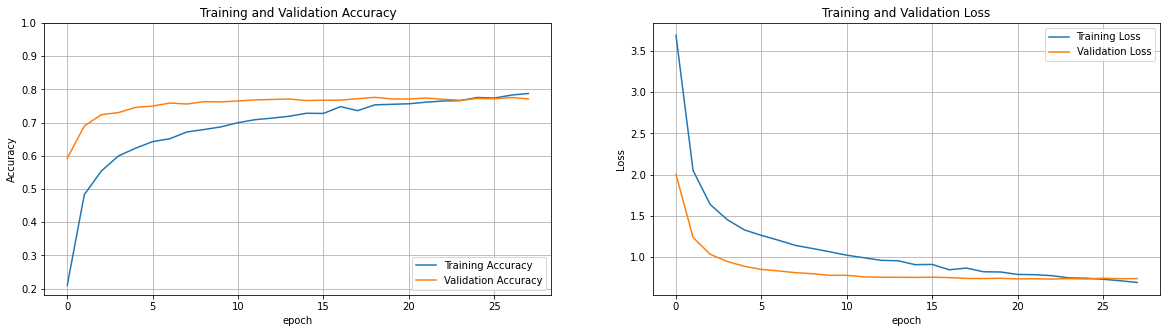

In [101]:
plot_learning_curves(history_mobilenet)

We can see that the validation metrics are better than the training metrics, the main cause is that layers like `BatchNormalization` and `Dropout` affect only the training accuracy.

# Fine tuning

To increase the performance of the model, let's try to unfreeze the top layers of the base model and retrain the whole model with a low learning rate. 

In [102]:
print(len(base_model_mobilenet.layers))

base_model_mobilenet.trainable = True
# Freeze the first 100 layers
for layer in base_model_mobilenet.layers[:100]:
  layer.trainable =  False

154


In [103]:
# Compile the model and start training
mobilenet_model.compile(optimizer=keras.optimizers.Adam(lr=1e-5), # low learning rate
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

history_mobilenet = mobilenet_model.fit(train_set_mobilenet, epochs=epochs, 
                                        validation_data=valid_set_mobilenet, 
                                        callbacks=[early_stopping_cb, tensorboard_cb])

Epoch 1/40
389/389 [==============================] - 38s 86ms/step - loss: 0.7337 - accuracy: 0.7702 - val_loss: 0.7253 - val_accuracy: 0.7689
Epoch 2/40
389/389 [==============================] - 34s 83ms/step - loss: 0.6661 - accuracy: 0.7929 - val_loss: 0.7233 - val_accuracy: 0.7719
Epoch 3/40
389/389 [==============================] - 33s 82ms/step - loss: 0.6694 - accuracy: 0.7865 - val_loss: 0.7390 - val_accuracy: 0.7706
Epoch 4/40
389/389 [==============================] - 34s 84ms/step - loss: 0.6301 - accuracy: 0.7999 - val_loss: 0.7342 - val_accuracy: 0.7716
Epoch 5/40
389/389 [==============================] - 34s 83ms/step - loss: 0.5798 - accuracy: 0.8159 - val_loss: 0.7323 - val_accuracy: 0.7743
Epoch 6/40
389/389 [==============================] - 34s 84ms/step - loss: 0.5571 - accuracy: 0.8255 - val_loss: 0.7180 - val_accuracy: 0.7755
Epoch 7/40
389/389 [==============================] - 34s 83ms/step - loss: 0.5461 - accuracy: 0.8266 - val_loss: 0.7224 - val_accuracy:

Fine-tuning seems not helped at all and the model start overfitting, so let's load and use the model without fine-tuning.

In [104]:
# Evaluate the final model on the test set
final_model = keras.models.load_model("mobilenet_without_fine_tuning.h5")
loss, accuracy = final_model.evaluate(test_set_mobilenet)
print('Test accuracy :', np.round((accuracy * 100), 2), '%')

128/128 [==============================] - 8s 44ms/step - loss: 0.7126 - accuracy: 0.7802
Test accuracy : 78.02 %


# Error analysis

Now that we have our final model, let's try to analyse the type of errors it makes.

Let's first plot the confusion matrix:

In [105]:
y_true = []
X_test = []
for images, labels in test_set_mobilenet:
    for X, y in zip(images, labels):
        y_true.append(y)
        X_test.append(X)
y_true = np.array(y_true)
X_test = np.array(X_test)
print(y_true, "shape:", y_true.shape)

[112  24  29 ...  83  72  62] shape: (4072,)


In [106]:
y_pred = final_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred.shape

(4072,)

The code below was copied from: [https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix](https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix)

<AxesSubplot:>

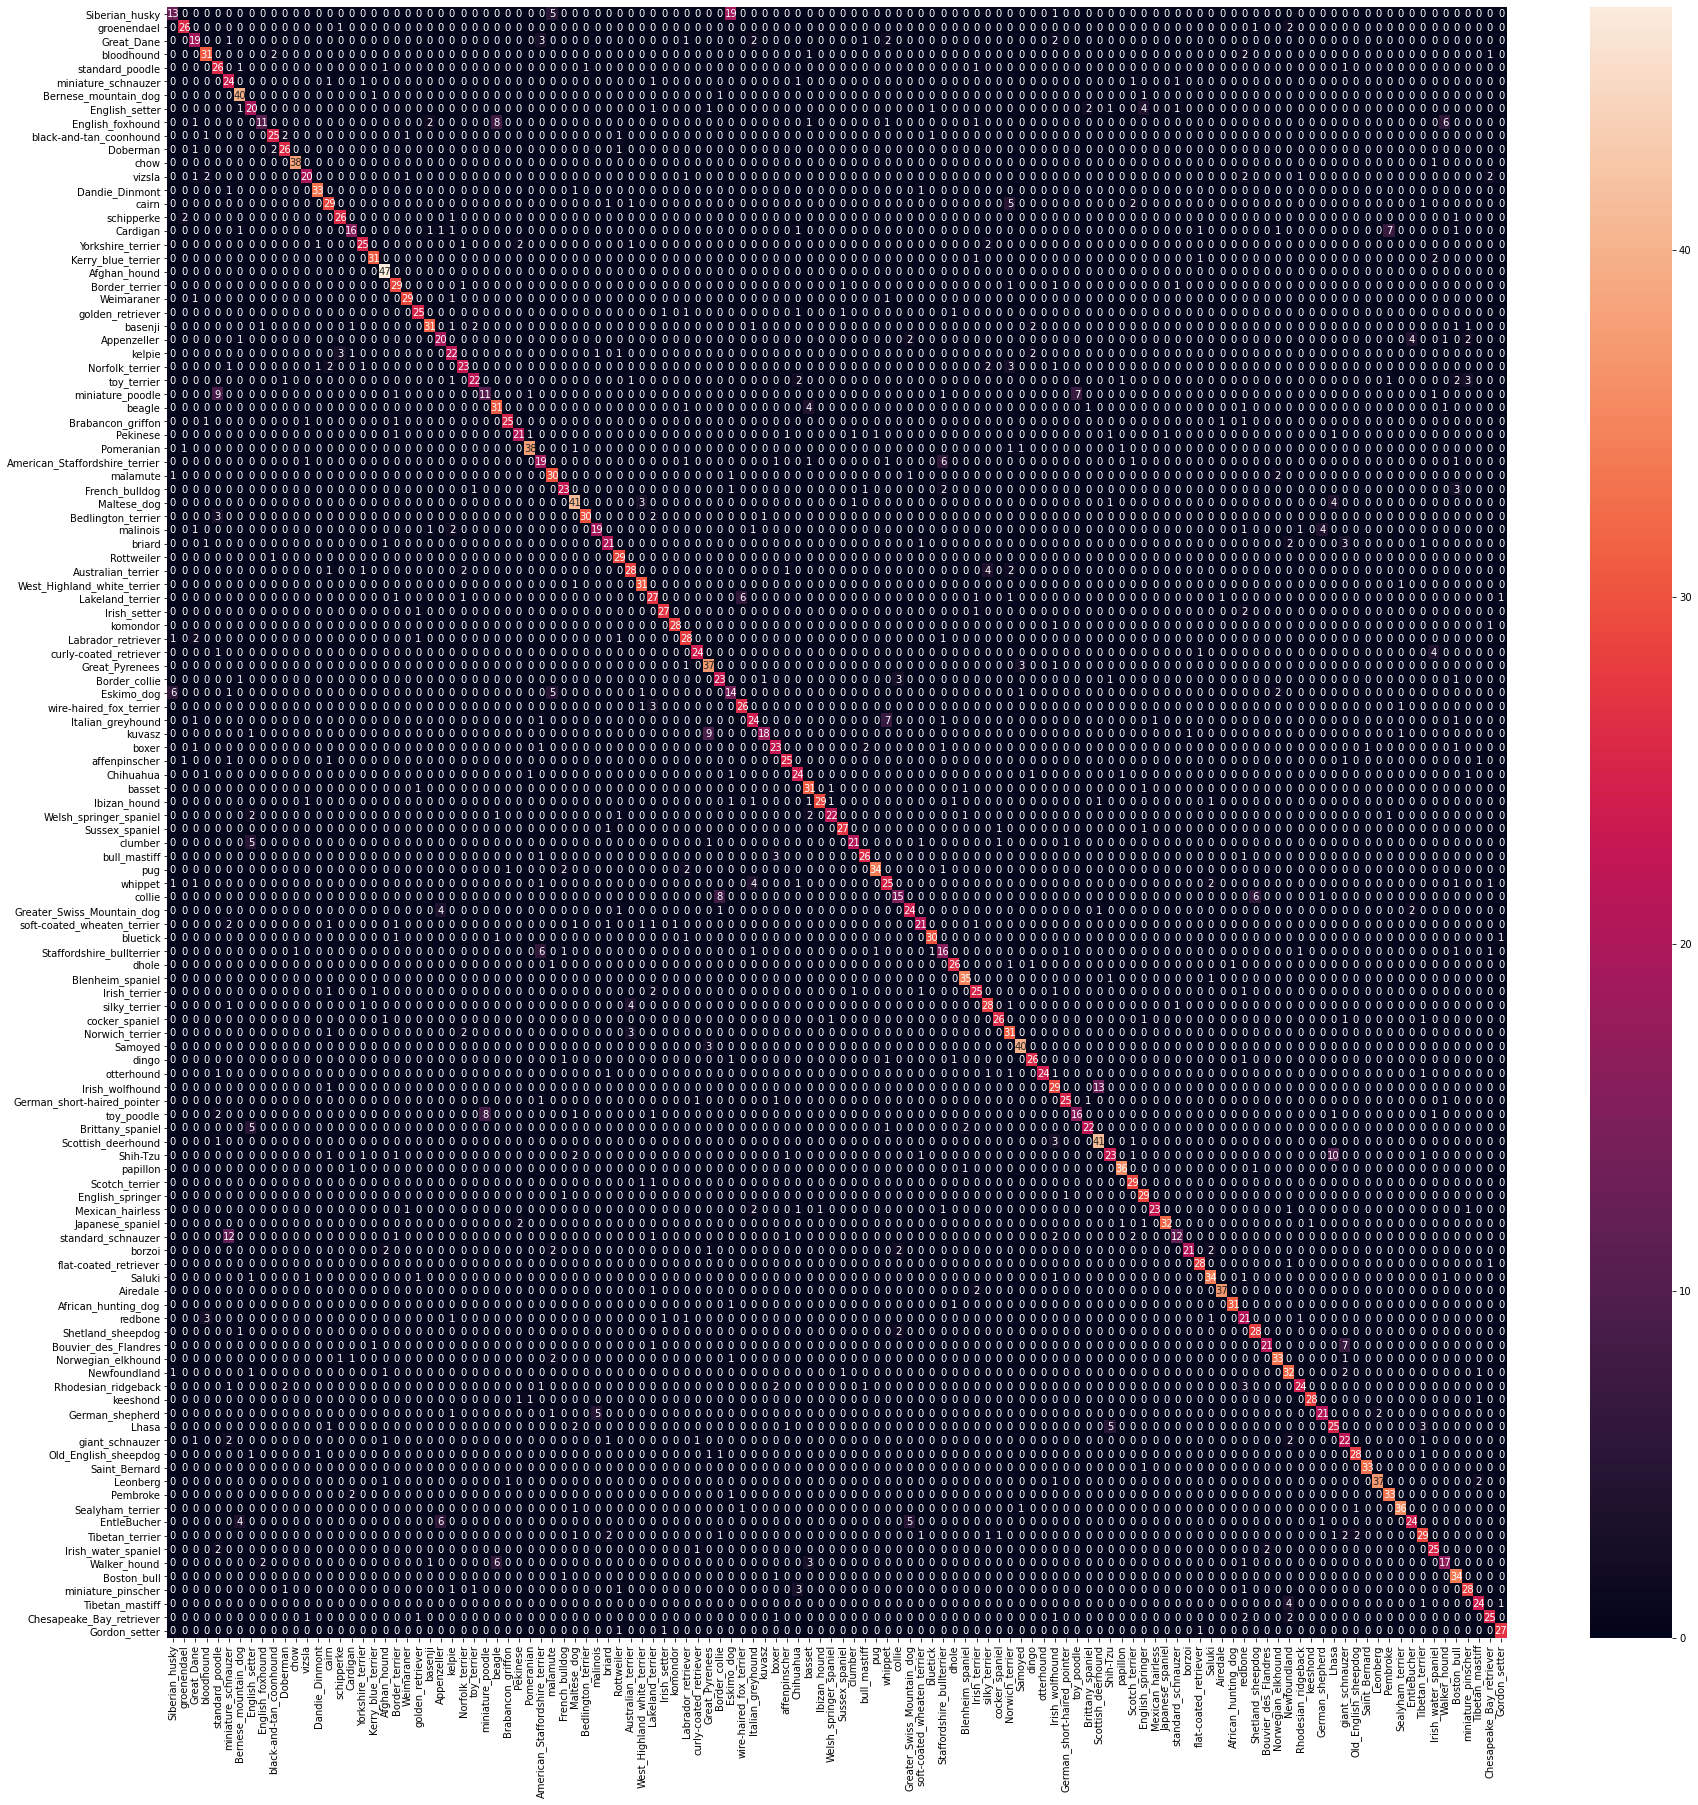

In [107]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

class_names = [class_[10:] for class_ in class_names] 

conf_mx = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(conf_mx, index=[i for i in class_names],
                      columns=[i for i in class_names])
plt.figure(figsize=(30,30))
sn.heatmap(df_cm, annot=True)

We can see that most images were classified correctly, since most of them are on the diagonal. The classes "Eskimo Dog", "Miniature Poodle", "Siberian Husky" and some others look slightly darker than the other classes, which means that there are fewer images of them or the model does not perform well on these images. For example, the model confused a lot of "Eskimo dog" images with the "Siberian husky" (the 1st class) which is understandable since the two races are very similar.

Let's try to use another metric: the F1 score. A high F1 score means that both precision and recall are high, which is what we want for our task.

In [108]:
from sklearn.metrics import classification_report
from collections import defaultdict
import pandas as pd

pd.set_option('display.max_rows', 500) # display the whole dataframe
dict_report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df = pd.DataFrame(dict_report).T
df = df.drop("accuracy").drop("macro avg").drop("weighted avg")
df.sort_values("f1-score")

,precision,recall,f1-score,support
Eskimo_dog,0.341463,0.466667,0.394366,30.0
Siberian_husky,0.565217,0.342105,0.426230,38.0
miniature_poodle,0.578947,0.354839,0.440000,31.0
English_foxhound,0.785714,0.354839,0.488889,31.0
standard_schnauzer,0.750000,0.387097,0.510638,31.0
Staffordshire_bullterrier,0.533333,0.516129,0.524590,31.0
American_Staffordshire_terrier,0.558824,0.593750,0.575758,32.0
collie,0.681818,0.500000,0.576923,30.0
English_setter,0.555556,0.625000,0.588235,32.0
Walker_hound,0.629630,0.566667,0.596491,30.0


We can see that the classes the model struggled to classify are: "Eskimo dog", "Siberian husky", "Miniature poodle", and "English foxhound".

Let's write a helper function that shows which classes the above classes (with low f1-score) have been confused with:

['Siberian_husky', 'miniature_schnauzer', 'malamute', 'West_Highland_white_terrier', 'Eskimo_dog', 'Samoyed', 'Norwegian_elkhound'] [6, 1, 5, 1, 14, 1, 2]


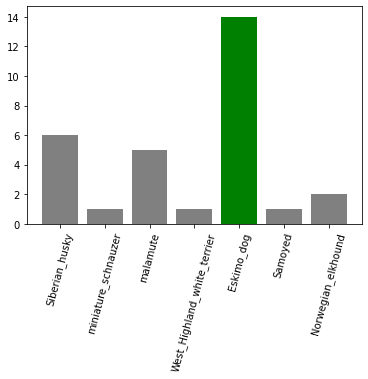

In [111]:
def plot_confused_classes(class_name):
    class_index = class_names.index(class_name)
    confusion_class = conf_mx[class_index] # shape (120,)
    classes = []
    freqencies = []
    for index, freq in enumerate(confusion_class):
        if freq != 0: # the model predict that the image belongs to this class
            classes.append(class_names[index])
            freqencies.append(freq)
    
    print(classes, freqencies)
    colors = ['g' if name == class_name else 'gray' for name in classes]
    plt.bar(classes, freqencies, color=colors)
    plt.xticks(rotation=75)
    plt.show()

plot_confused_classes('Eskimo_dog')

['Siberian_husky', 'malamute', 'Eskimo_dog', 'Irish_wolfhound'] [13, 5, 19, 1]


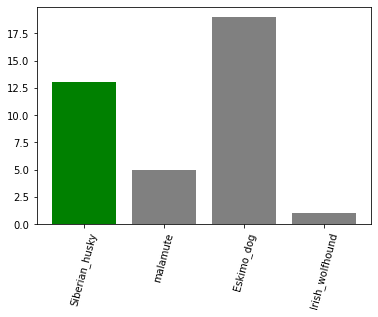

In [112]:
plot_confused_classes('Siberian_husky')

['standard_poodle', 'Border_terrier', 'miniature_poodle', 'Pomeranian', 'Staffordshire_bullterrier', 'toy_poodle', 'Irish_water_spaniel'] [9, 1, 11, 1, 1, 7, 1]


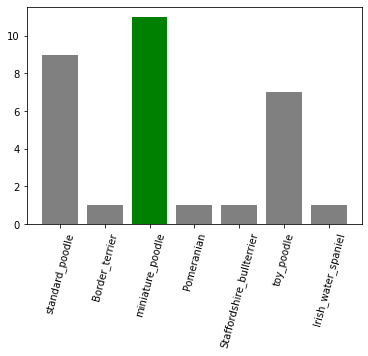

In [113]:
plot_confused_classes('miniature_poodle')

['Great_Dane', 'English_foxhound', 'basenji', 'beagle', 'basset', 'whippet', 'Irish_terrier', 'Walker_hound'] [1, 11, 2, 8, 1, 1, 1, 6]


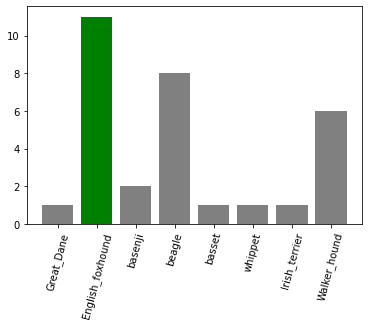

In [114]:
plot_confused_classes('English_foxhound')

By analysing the errors the model makes, we can say that there are several ways to improve it:
* Gather more training data for classes the model struggeled to classify.
* Get images with better quality.
* Increase the size of the dataset.